In [1]:
import warnings
warnings.simplefilter(action="ignore")

In [2]:
from data_load import load_data
from data_visualization import visualize_volume_avg_hour, visualize_vpin_and_gap_time
from data_processing import (
    transform_avg_volume_hourly,
    transform_buy_sell_volume,
    calculate_V,
    calculate_bucket_number,
    calculate_vpin,
    calcualate_gap_time_faction_of_the_day,
)

In [3]:
# Load data
data_tick = load_data()
data_orderbook = load_data(folder="orderbook")
data_vn30_index = load_data(folder="")

## PHẦN 1: VOLUME THEO THỜI GIAN

In [4]:
key1 = "STB"
key2 = "SAB"
STB_avg_hourly, SAB_avg_hourly = transform_avg_volume_hourly(data_tick)
SAB_avg_hourly, STB_avg_hourly

(   Hour         KL
 0     9  58.772920
 1    10  54.110919
 2    11  42.729430
 3    13  55.199203
 4    14  54.119795,
    Hour          KL
 0     9  238.257788
 1    10  219.788697
 2    11  223.656007
 3    13  250.128809
 4    14  275.724979)

- Vì sàn chứng khoáng Việt Nam chỉ giao dịch từ:
    - 9h sáng 11h30 trưa
    - Nghỉ trưa từ 11h30 đến 13h chiều
    - Hoặt động lại từ 13h chiều đến 15h00 chiều
- Do đó dữ liệu theo giờ chỉ có ở các mốc 9, 10, 11, 13, 14 (làm tròn lùi theo giờ)

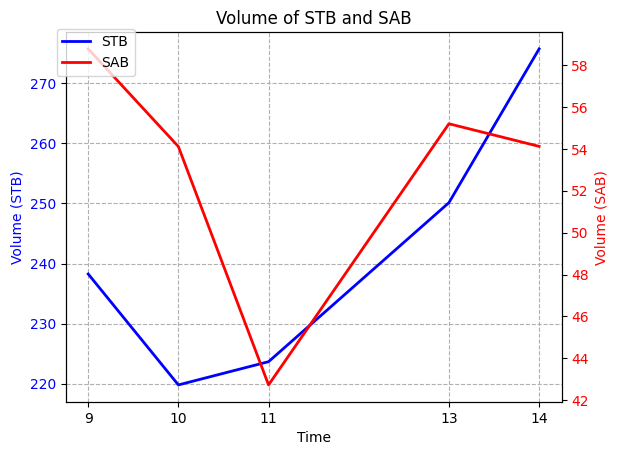

In [5]:
visualize_volume_avg_hour(STB_avg_hourly, SAB_avg_hourly)

## PHẦN 2: VPIN

In [6]:
# Chọn ra 1 loại cổ phiêú
key1 = "STB"
STB = transform_buy_sell_volume(data_orderbook, key1=key1)
STB.head()

,Date,KL_mua,KL_ban,KL
0,2024-09-23 13:00:05,39880.0,119180.0,159060.0
1,2024-09-23 13:00:07,39740.0,0.0,39740.0
2,2024-09-23 13:00:09,0.0,60260.0,60260.0
3,2024-09-23 13:00:10,0.0,60470.0,60470.0
4,2024-09-23 13:00:13,39650.0,0.0,39650.0


In [7]:
# # Tính V
V, STB = calculate_V(STB)
V

np.float64(10597695.6)

In [8]:
# # Chia bucket
bucket_df = calculate_bucket_number(STB, V)
bucket_df.head()

,index,Date,KL_mua,KL_ban,KL,Date_only,bucket_number
0,741,2024-09-24 09:30:11,0.0,38620.0,38620.0,2024-09-24,1
1,742,2024-09-24 09:30:20,0.0,38610.0,38610.0,2024-09-24,1
2,743,2024-09-24 09:30:25,23870.0,0.0,23870.0,2024-09-24,1
3,744,2024-09-24 09:30:27,23770.0,0.0,23770.0,2024-09-24,1
4,745,2024-09-24 09:30:31,23660.0,0.0,23660.0,2024-09-24,1


In [9]:
# Tính vpin
vpin_df = calculate_vpin(bucket_df, n=50, V=V)
vpin_df.head()

,start_bucket_time,end_bucket_time,vpin,gap_time,start_bucket,end_bucket
0,2024-09-24 09:30:11,2024-09-24 09:58:58,0.475575,1727.0,1,50
1,2024-09-24 09:58:58,2024-09-24 10:23:17,0.478128,1459.0,2,51
2,2024-09-24 10:23:17,2024-09-24 10:36:59,0.482846,822.0,3,52
3,2024-09-24 10:36:59,2024-09-24 10:46:12,0.488788,553.0,4,53
4,2024-09-24 10:46:12,2024-09-24 10:57:18,0.479989,666.0,5,54


In [10]:
# Tính Time gap faction of the day
vpin_df = calcualate_gap_time_faction_of_the_day(vpin_df)
vpin_df.head()

,start_bucket_time,end_bucket_time,vpin,gap_time,start_bucket,end_bucket,gap_time_faction_of_the_day
0,2024-09-24 09:30:11,2024-09-24 09:58:58,0.475575,1727.0,1,50,0.106605
1,2024-09-24 09:58:58,2024-09-24 10:23:17,0.478128,1459.0,2,51,0.090062
2,2024-09-24 10:23:17,2024-09-24 10:36:59,0.482846,822.0,3,52,0.050741
3,2024-09-24 10:36:59,2024-09-24 10:46:12,0.488788,553.0,4,53,0.034136
4,2024-09-24 10:46:12,2024-09-24 10:57:18,0.479989,666.0,5,54,0.041111


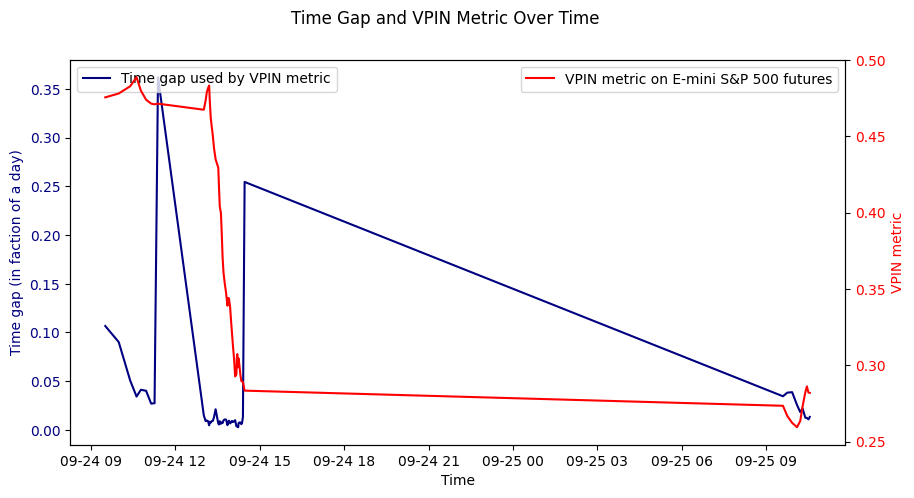

In [11]:
visualize_vpin_and_gap_time(vpin_df.head(60))

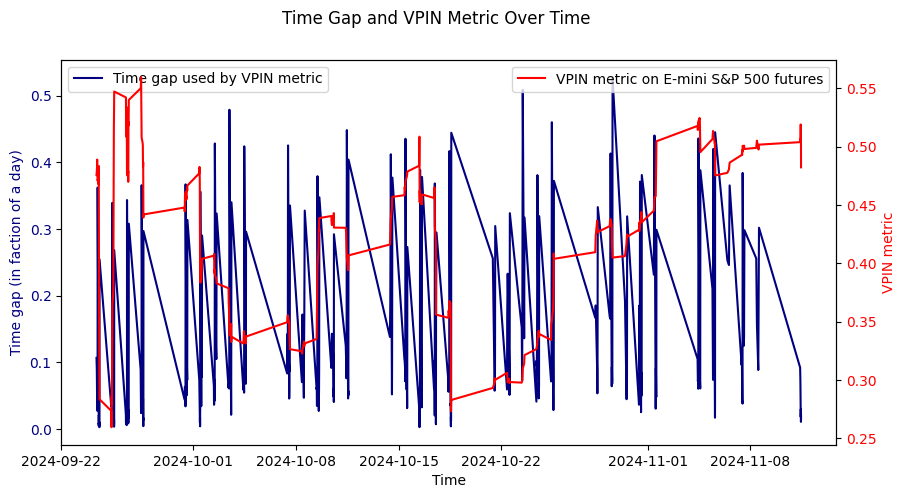

In [12]:
visualize_vpin_and_gap_time(vpin_df)

In [13]:
vpin_df.tail(60)

,start_bucket_time,end_bucket_time,vpin,gap_time,start_bucket,end_bucket,gap_time_faction_of_the_day
448,2024-10-31 13:14:29,2024-10-31 13:37:37,0.436776,1388.0,449,498,0.085679
449,2024-10-31 13:37:37,2024-10-31 13:50:56,0.443857,799.0,450,499,0.049321
450,2024-10-31 13:50:56,2024-10-31 14:06:54,0.440564,958.0,451,500,0.059136
451,2024-10-31 14:06:54,2024-10-31 14:21:16,0.434809,862.0,452,501,0.053210
452,2024-10-31 14:21:16,2024-11-01 10:04:05,0.435030,6169.0,453,502,0.380802
453,2024-11-01 10:04:05,2024-11-01 11:06:33,0.445019,3748.0,454,503,0.231358
454,2024-11-01 11:06:33,2024-11-01 13:05:22,0.456448,7129.0,455,504,0.440062
455,2024-11-01 13:05:22,2024-11-01 13:13:36,0.457321,494.0,456,505,0.030494
456,2024-11-01 13:13:36,2024-11-01 13:29:41,0.457883,965.0,457,506,0.059568
457,2024-11-01 13:29:41,2024-11-01 13:54:16,0.467191,1475.0,458,507,0.091049
